# Irrotational random flow
Last updated: 3 March 2022

**Setup**

In [1]:
import numpy as np
import skimage.filters
import scipy.ndimage
import scipy.sparse

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt

# Lima
import lima

In [2]:
lima.plot.init_mpl_style()

In [3]:
debug = False

In [4]:
subplotgrid = [  
    [1, 1, 2, 2, 3, 3],
    [0, 4, 4, 5, 5, 0],
]

**Functions**

In [5]:
def vortZ(u, v):
    dudy, dudx = np.gradient(u)
    dvdy, dvdx = np.gradient(v)
    return dvdx - dudy

def divUV(u, v):
    dudy, dudx = np.gradient(u)
    dvdy, dvdx = np.gradient(v)
    return dudx + dvdy

def random_dataset(vscale=1.0, height=256, width=256, filter_size=5, seed=None):
    if seed:
        np.random.seed(seed)
    # Coordinates
    x, y = np.meshgrid(np.arange(height, dtype='float32'),
                       np.arange(width, dtype='float32'))

    #u, v = np.random.rand(2, height, width).astype('float32') - 0.5
    u, v = np.random.uniform(-1, 1, size=(2, height, width)).astype('float32')
    u = skimage.filters.gaussian(u, filter_size, mode='reflect')
    v = skimage.filters.gaussian(v, filter_size, mode='reflect')
    u = u/np.abs(u).max() * vscale
    v = v/np.abs(v).max() * vscale
    # Parameters
    #print(np.max(u), np.max(v))
    return x, y, u, v

def quiver(ax, x, y, u, v, skip=1, *args, **kwargs):
    return ax.quiver(
        x[::skip, ::skip], y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip],
        *args, **kwargs
    )

norm = lambda u,v: np.sqrt(u**2 + v**2)

## Pure-random flow

In [36]:
filter_size = 5
vscale = 1
height = width = 256

In [37]:
# Random dist.
np.random.seed(234)

x, y, _,_ = random_dataset(vscale=1, height=height, width=width, filter_size=filter_size)
u, v = np.random.uniform(-1, 1, size=(2, height, width)).astype('float32')

# Filtered
uf = skimage.filters.gaussian(u, filter_size, mode="reflect")#, preserve_range=True) 
vf = skimage.filters.gaussian(v, filter_size, mode="reflect")#, preserve_range=True)
uf = uf/np.abs(uf).max() * vscale
vf = vf/np.abs(vf).max() * vscale
# Scaled
us = uf
vs = vf

In [38]:
if debug:
    fig = pplt.figure(refwidth='12em', span=False)
    axes = fig.subplots(ncols=2)

    # Original
    im = axes[0].pcolor(vortZ(u, v), vmin=-1, vmax=1, cmap='turbo')
    cb = axes[0].colorbar(im, label='$\omega_z$', width='0.75em')

    # Filtered
    im = axes[1].imshow(vortZ(us, vs),  interpolation='none', cmap='turbo')
    cb = axes[1].colorbar(im, label='$\omega_z$', width='0.75em')

    # Quiver
    quiver(axes[1], x, y, us, vs, skip=2, color='k', scale=5)

    # Format
    axes.format(
        abc='(a)', abcloc='ul', abcbbox=True,
        xlabel='$x$ (px)', ylabel='$y$ (px)',
        suptitle='Pure random vector field',
    )

**Rotational and irrotational component**

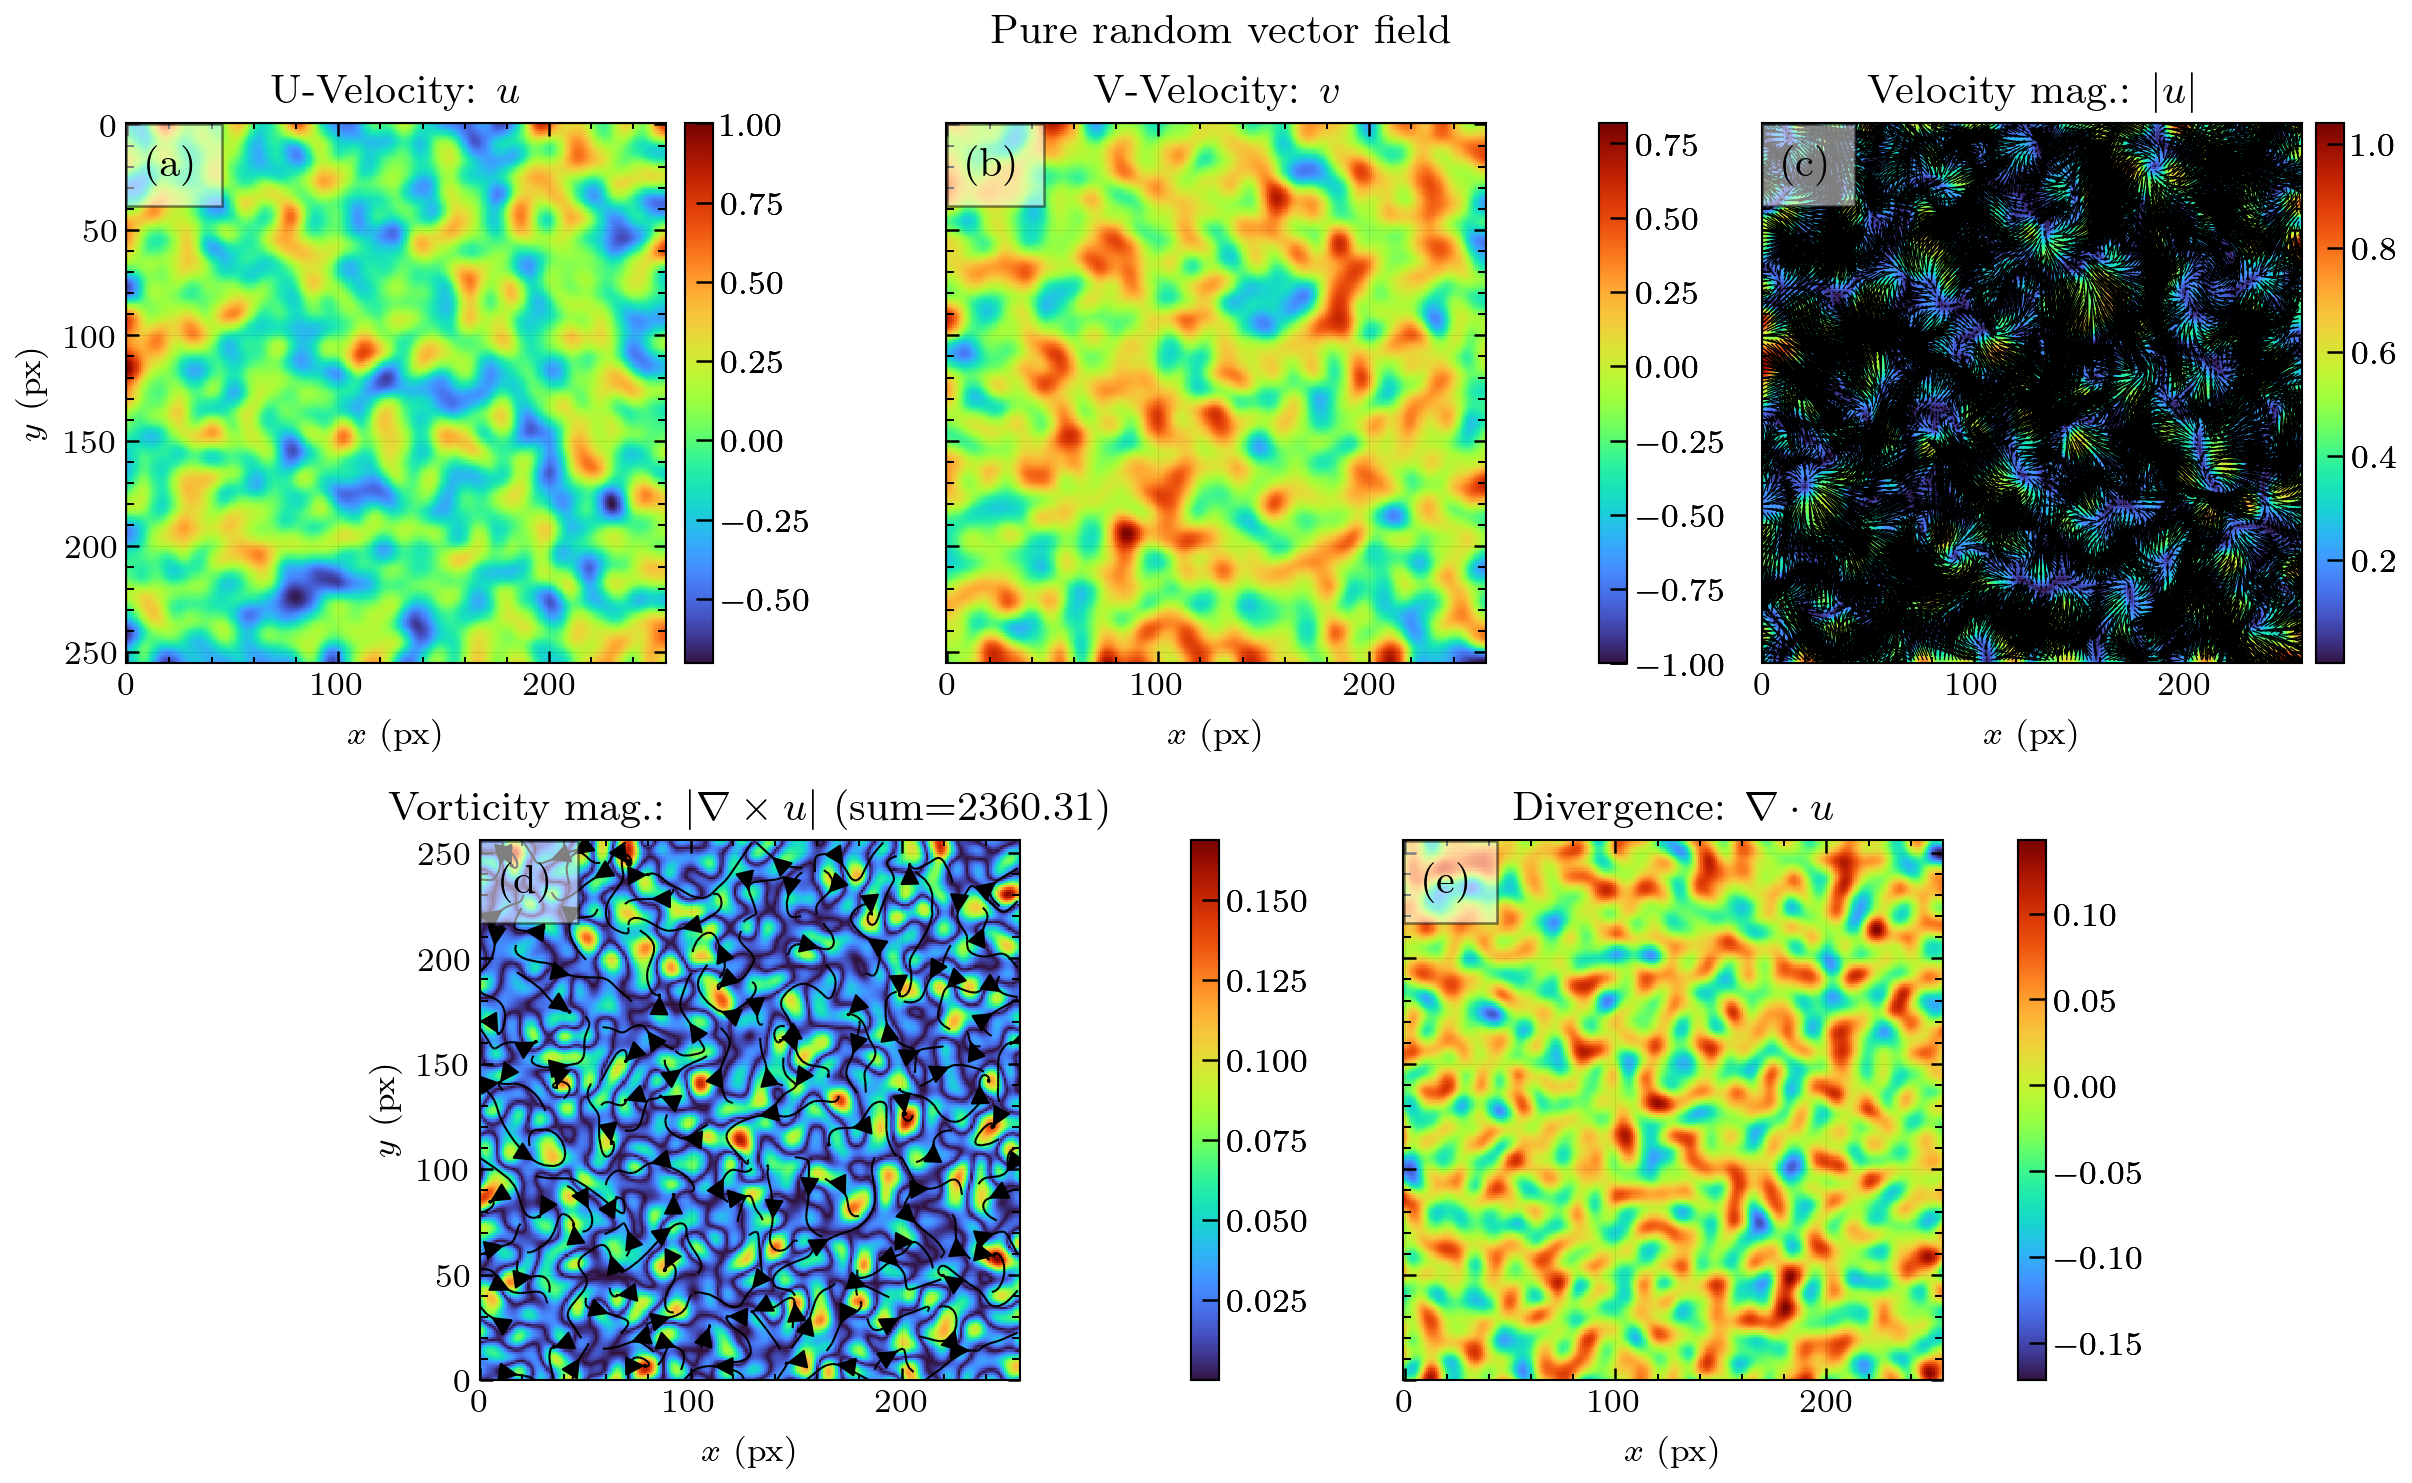

In [39]:
fig = pplt.figure(refwidth='1.8', span=False)
axes = fig.subplots(subplotgrid)

s = 5
# u
ax = axes[0]
im = ax.imshow(us,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"U-Velocity: $u$")

# v
ax = axes[1]
im = ax.imshow(vs,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"V-Velocity: $v$")

# |u| 
ax = axes[2]
im = ax.imshow((us**2 + vs**2)**0.5,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
quiver(ax, x, y, us, vs, skip=2, color='k', scale=s)
ax.format(title=r"Velocity mag.: $|u|$")

# vorticity |u| 
ax = axes[3]
im = ax.imshow(np.abs(vortZ(us, vs)), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=fr"Vorticity mag.: $|\nabla \times u|$ (sum={np.abs(vortZ(us, vs)).sum():2g})")
ax.streamplot(x, y, us, vs, c='k', lw=0.5)
ax.axis([0, height, 0, width])

# divergence |u| 
ax = axes[4]
im = ax.imshow(divUV(us, vs), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"Divergence: $\nabla \cdot u$")

# Quiver

# # Format
axes.format(
    abc='(a)', abcloc='ul', abcbbox=True,
    xlabel='$x$ (px)', ylabel='$y$ (px)',
    suptitle='Pure random vector field',
)

---
## Irrotational Flow

1. Perform helmholtz decomposition: 
$$
u = -\nabla \phi + \nabla \times \psi
$$
2. Construct poisson equation by taking divergence of velocity:
$$
\nabla \cdot u = -\nabla^2 \phi \equiv f
$$
3. Solve poisson equation using iterative method (relaxation method) or directly.
4. Calculate irrotation velocity: 
$$
u_{\phi} = -\nabla \phi
$$

### (Approach 1): Solve discrete poisson equation: (relaxation method)

Solve using relaxation method: $\psi^* = 1/4 \left[\phi(x+h,y) + \phi(x,y+h) + \phi(x-h,y)+\phi(x,y-h) - h^2f(x,y)\right]$


The 2D poisson equation is:
$$
\nabla^2 \phi = f
$$
or in 2D cartesian:
$$
\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = f
$$

In discretize form (central):
$$
\frac{\phi^n_{i+1,j} - 2\phi^n_{i,j} + \phi^n_{i-1,j}}{\Delta x^2} + \frac{\phi^n_{i,j+1} - 2\phi^n_{i,j} + \phi^n_{i,j-1}}{\Delta y^2} = f^n_{i,j}
$$
and rearranging for $\phi^n_{i,j}$:
$$
\phi^n_{i,j} = \frac{(\phi^n_{i+1,j} + \phi^n_{i-1,j})\Delta y^2 + (\phi^n_{i,j+1} + \phi^n_{i,j-1})\Delta x^2 - f^n_{i,j}\Delta x^2 \Delta y^2}{2(\Delta x^2 + \Delta y^2)}
$$



### (Approach 2) Solve discrete poisson equation: (Directly)

The 2D poisson equation is:
$$
\nabla^2 \phi = f
$$
or in 2D cartesian:
$$
\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = f
$$

In discretize form (central):
$$
\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta y^2} = f_{i,j}
$$

Define the discrete Laplacian, i.e., the Laplacian matrix $L$, we then need to solve the system of equation:
$$
L \phi = f
$$


**Construct the Sparse A matrix** (LHS)

In [40]:
# Discrete laplacian operator
nx, ny = us.shape
assert nx==ny, f"must be square, {nx=}, {ny=}"
n = nx*ny
h = 1

In [41]:
B = np.zeros((5, n))

for i in range(ny):
    for j in range(nx):
        k = j*nx + i
        if i == 0:
            if j == 0:
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]  = -2*h/(h + h)
                B[4, k+nx] = -2*h/(h + h)
            elif j == nx-1:
                B[0, k-nx] = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]  = -2*h/(h + h)
            else:
                B[0, k-nx] = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]  = -2*h/(h + h)
                B[4, k+nx] = -2*h/(h + h)
        elif i == nx-1:
            if j == 0:
                B[1, k-1]  = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                B[4, k+nx] = -2*h/(h + h)
            elif j == nx-1:
                B[0, k-nx] = -2*h/(h + h)
                B[1, k-1]  = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
            else:
                B[0, k-nx] = -2*h/(h + h)
                B[1, k-1]  = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                B[4, k+nx] = -2*h/(h + h)
        elif j == 0:
            if ( i > 0 and i < nx-1 ):
                B[1, k-1]  = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]  = -2*h/(h + h)
                B[4, k+nx] = -2*h/(h + h)
        elif j == nx-1:
            if ( i > 0 and i < nx-1 ):
                B[0, k-nx] = -2*h/(h + h)
                B[1, k-1]  = -2*h/(h + h)
                B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]  = -2*h/(h + h)
        else:
            B[0, k-nx]     = -2*h/(h + h)
            B[1, k-1]      = -2*h/(h + h)
            B[2, k]        =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
            B[3, k+1]      = -2*h/(h + h)
            B[4, k+nx]     = -2*h/(h + h)

In [42]:
# Diagonal indices
diags = np.array([-nx, -1, 0, 1, nx])

# Construct sparse diagonal matrix
L = scipy.sparse.spdiags(B, diags, n, n).tocsr()
L

<65536x65536 sparse matrix of type '<class 'numpy.float64'>'
	with 326656 stored elements in Compressed Sparse Row format>

**Inspect LHS**

In [13]:
if debug:
    print(f"Condition number: {np.linalg.cond(L.todense())}!!!")

In [43]:
if debug:
    fig = pplt.figure()
    ax = fig.gca()
    im = ax.matshow(L.toarray(), cmap='turbo')
    ax.colorbar(im)

**Construct the RHS**

In [44]:
f = -divUV(us, vs)
f = f.reshape(n)

**Solve the poisson equation**

*Dense*

In [45]:
%%time
if debug:
    Ldense = L.toarray()
    phi = np.linalg.solve(Ldense, f) # dense
    print(f"Residual: {np.sum(np.abs(Ldense.dot(phi) - f))}")

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.6 µs


*Sparse method (direct)*: **FASTEST**

In [46]:
%%time
phi = scipy.sparse.linalg.spsolve(L, f)
print(f"Residual: {np.sum(np.abs(L.dot(phi) - f))}")

Residual: 286.94013554858975
CPU times: user 6.17 s, sys: 293 ms, total: 6.46 s
Wall time: 636 ms


*Sparse method (iterative: GMRES)*

In [55]:
%%time
# if debug:
phi, info = scipy.sparse.linalg.gmres(L, f, x0=us.ravel(), maxiter=100)
# phi, info = scipy.sparse.linalg.minres(L, f, maxiter=5000)
print(f"Residual: {np.sum(np.abs(L.dot(phi) - f))}")
if info:
    print(f"Not converged!!")

Residual: 36.657510615374996
Not converged!!
CPU times: user 22.5 s, sys: 900 ms, total: 23.4 s
Wall time: 1.95 s


### Calculate irrotational velocity

The irrotation velocity component is defined as:
$$
u_{\phi} = -\nabla \phi
$$

where
$$
\begin{aligned}
u_{x,\phi} &= \frac{\partial \phi}{\partial x}\\
u_{y,\phi} &= \frac{\partial \phi}{\partial y}
\end{aligned}
$$


In [56]:
v_phi, u_phi = np.gradient(phi.reshape(nx, ny))

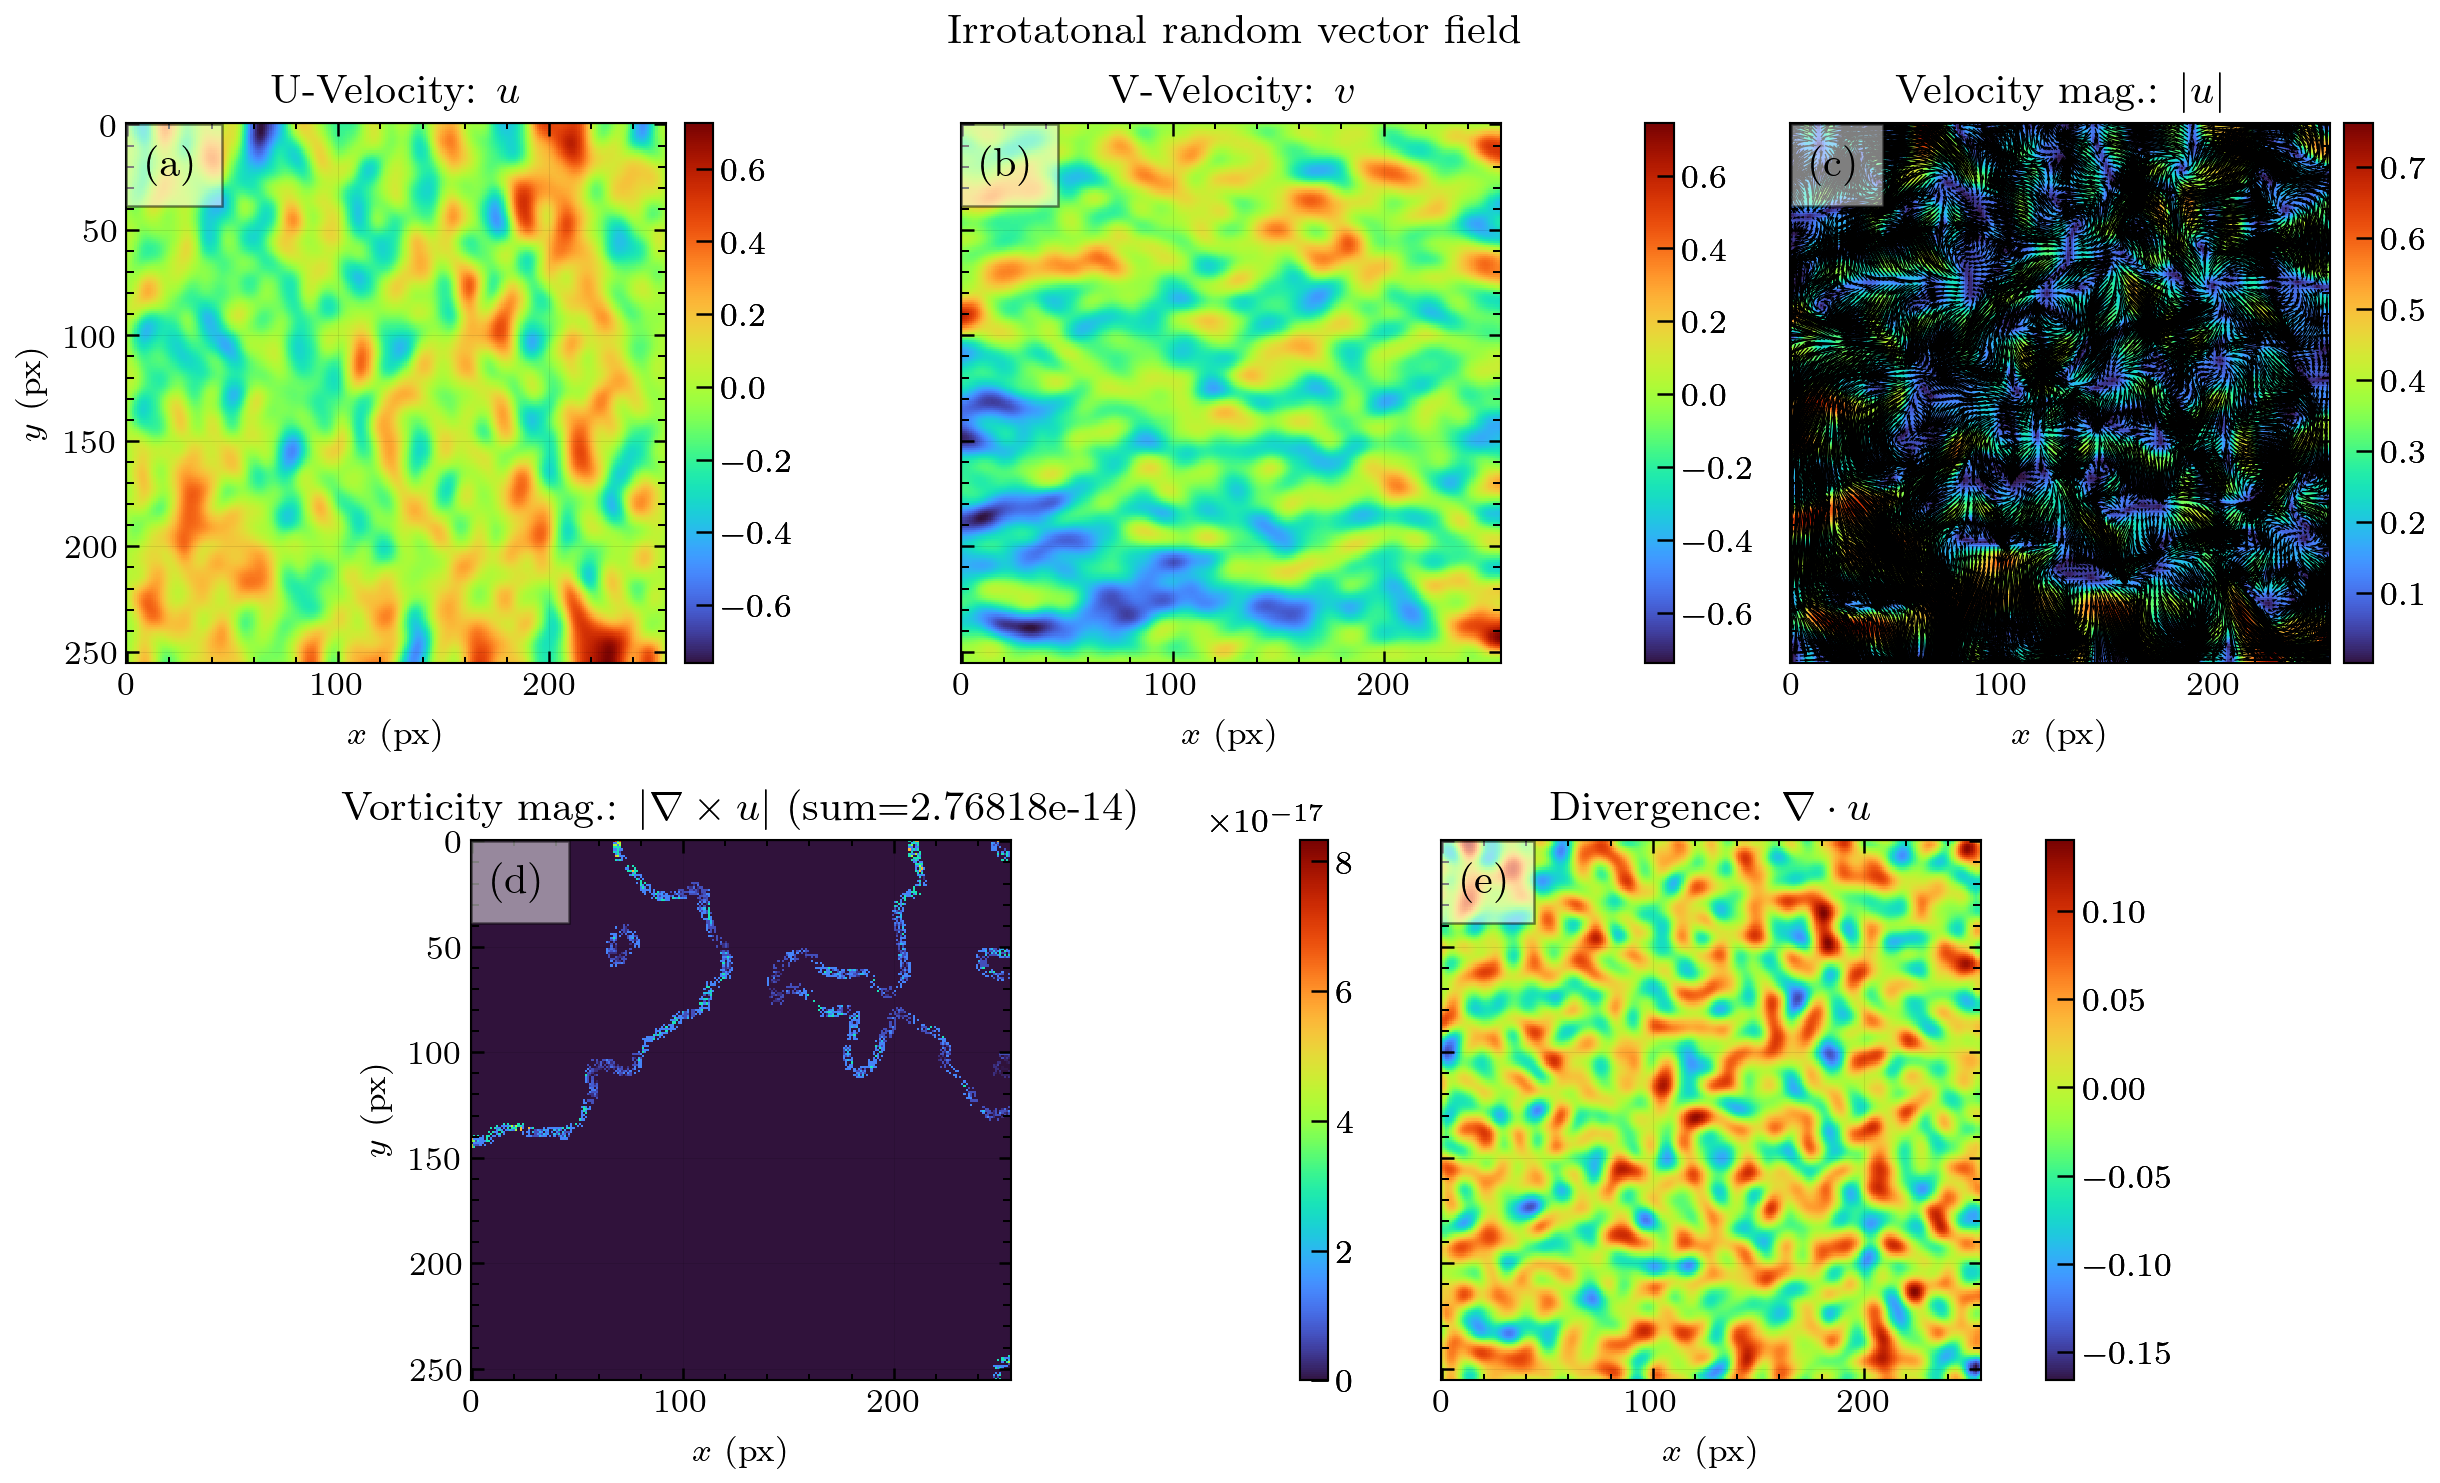

In [58]:
fig = pplt.figure(refwidth='1.8', span=False)
axes = fig.subplots(subplotgrid)

s = 5
# u
ax = axes[0]
im = ax.imshow(u_phi,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
# quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"U-Velocity: $u$")

# v
ax = axes[1]
im = ax.imshow(v_phi,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
# quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"V-Velocity: $v$")

# |u| 
ax = axes[2]
im = ax.imshow((u_phi**2 + v_phi**2)**0.5,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"Velocity mag.: $|u|$")
# ax.streamplot(x, y, u_phi, v_phi, c='k', lw=0.5)
# ax.axis([0, height, 0, width])

# vorticity |u| 
ax = axes[3]
im = ax.imshow(np.abs(vortZ(u_phi, v_phi)), interpolation='none')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=fr"Vorticity mag.: $|\nabla \times u|$ (sum={np.abs(vortZ(u_phi, v_phi)).sum():2g})")

# divergence |u| 
ax = axes[4]
im = ax.imshow(divUV(u_phi, v_phi), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"Divergence: $\nabla \cdot u$")
# ax.axis([0,64,0,64])

# Quiver

# # Format
axes.format(
    abc='(a)', abcloc='ul', abcbbox=True,
    xlabel='$x$ (px)', ylabel='$y$ (px)',
    suptitle='Irrotatonal random vector field',
)